# Przewidywanie zawału na podstawie danych medycznych


Zbiór danych: www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset

In [1]:
from sklearn.linear_model import LinearRegression ,LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC ,SVR
from sklearn.metrics import *
from sklearn.model_selection import GridSearchCV

import os
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split 

import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE

In [2]:
df = pd.read_csv('healthcare-dataset-stroke-data.csv')
df

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5105,18234,Female,80.0,1,0,Yes,Private,Urban,83.75,NaN,never smoked,0
5106,44873,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.0,never smoked,0
5107,19723,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0
5108,37544,Male,51.0,0,0,Yes,Private,Rural,166.29,25.6,formerly smoked,0


# Opis danych

* 1) id: unique identifier
* 2) gender: "Male", "Female" or "Other"
* 3) age: age of the patient
* 4) hypertension: 0 if the patient doesn't have hypertension, 1 if the patient has hypertension
* 5) heart_disease: 0 if the patient doesn't have any heart diseases, 1 if the patient has a heart disease
* 6) ever_married: "No" or "Yes"
* 7) work_type: "children", "Govt_jov", "Never_worked", "Private" or "Self-employed"
* 8) Residence_type: "Rural" or "Urban"
* 9) avg_glucose_level: average glucose level in blood
* 10) bmi: body mass index
* 11) smoking_status: "formerly smoked", "never smoked", "smokes" or "Unknown"*
* 12) stroke: 1 if the patient had a stroke or 0 if not
* *Note: "Unknown" in smoking_status means that the information is unavailable for this patient

Usuwamy zbędną kolumnę: id

In [3]:
del df["id"]

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             5110 non-null   object 
 1   age                5110 non-null   float64
 2   hypertension       5110 non-null   int64  
 3   heart_disease      5110 non-null   int64  
 4   ever_married       5110 non-null   object 
 5   work_type          5110 non-null   object 
 6   Residence_type     5110 non-null   object 
 7   avg_glucose_level  5110 non-null   float64
 8   bmi                4909 non-null   float64
 9   smoking_status     5110 non-null   object 
 10  stroke             5110 non-null   int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 439.3+ KB


Kolumna bmi ma wartości typu null, jest ich około 2%, więc usuniemy wiersze zawierające te wartości

In [5]:
df=df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4909 entries, 0 to 5109
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             4909 non-null   object 
 1   age                4909 non-null   float64
 2   hypertension       4909 non-null   int64  
 3   heart_disease      4909 non-null   int64  
 4   ever_married       4909 non-null   object 
 5   work_type          4909 non-null   object 
 6   Residence_type     4909 non-null   object 
 7   avg_glucose_level  4909 non-null   float64
 8   bmi                4909 non-null   float64
 9   smoking_status     4909 non-null   object 
 10  stroke             4909 non-null   int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 460.2+ KB


Teraz sprawdzimy kolumny zawierające dane nienumeryczne

In [6]:
print(df["gender"].value_counts())
print(df["ever_married"].value_counts())
print(df["Residence_type"].value_counts())
print(df["smoking_status"].value_counts())
print(df["work_type"].value_counts())

Female    2897
Male      2011
Other        1
Name: gender, dtype: int64
Yes    3204
No     1705
Name: ever_married, dtype: int64
Urban    2490
Rural    2419
Name: Residence_type, dtype: int64
never smoked       1852
Unknown            1483
formerly smoked     837
smokes              737
Name: smoking_status, dtype: int64
Private          2811
Self-employed     775
children          671
Govt_job          630
Never_worked       22
Name: work_type, dtype: int64


Kolumna gender zawiera 3 wartości, jedna z nich występuje tylko 1 raz więc usuniemy wiersz zawierający ją.

In [7]:
df = df.drop(df[df.gender == "Other"].index)

Następnie mapujemy dane nienumeryczne na dane numeryczne

In [8]:
mapping_dict = {
    "gender": {
        "Male": 1,
        "Female": 0
    },
    "ever_married": {
        "Yes": 1,
        "No": 0
    },
    "Residence_type": {
        "Urban": 1,
        "Rural": 0
    },
    "work_type": {
        "Private": 2,
        "Self-employed": 3,
        "Govt_job": 1,
        "children": 0,
        "Never_worked": 4
    },
    "smoking_status": {
        "never smoked": 0,
        "Unknown": 1,
        "formerly smoked": 2,
        "smokes": 3
    }
}
df = df.replace(mapping_dict)
df

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,1,67.0,0,1,1,2,1,228.69,36.6,2,1
2,1,80.0,0,1,1,2,0,105.92,32.5,0,1
3,0,49.0,0,0,1,2,1,171.23,34.4,3,1
4,0,79.0,1,0,1,3,0,174.12,24.0,0,1
5,1,81.0,0,0,1,2,1,186.21,29.0,2,1
...,...,...,...,...,...,...,...,...,...,...,...
5104,0,13.0,0,0,0,0,0,103.08,18.6,1,0
5106,0,81.0,0,0,1,3,1,125.20,40.0,0,0
5107,0,35.0,0,0,1,3,0,82.99,30.6,0,0
5108,1,51.0,0,0,1,2,0,166.29,25.6,2,0


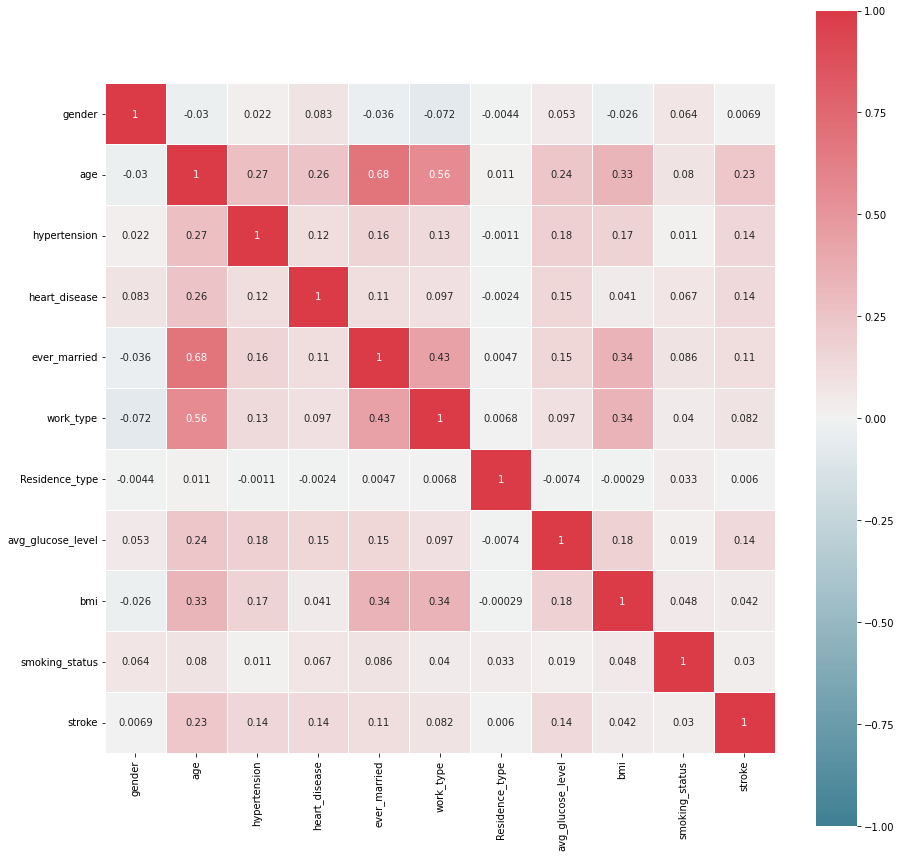

In [9]:
corr = df.corr()
f, ax = plt.subplots(figsize=(15, 15))
cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.heatmap(corr, cmap=cmap, annot = True, vmin=-1, vmax=1,
            square=True, xticklabels=True, yticklabels=True,
            linewidths=.5, ax=ax)
plt.show()

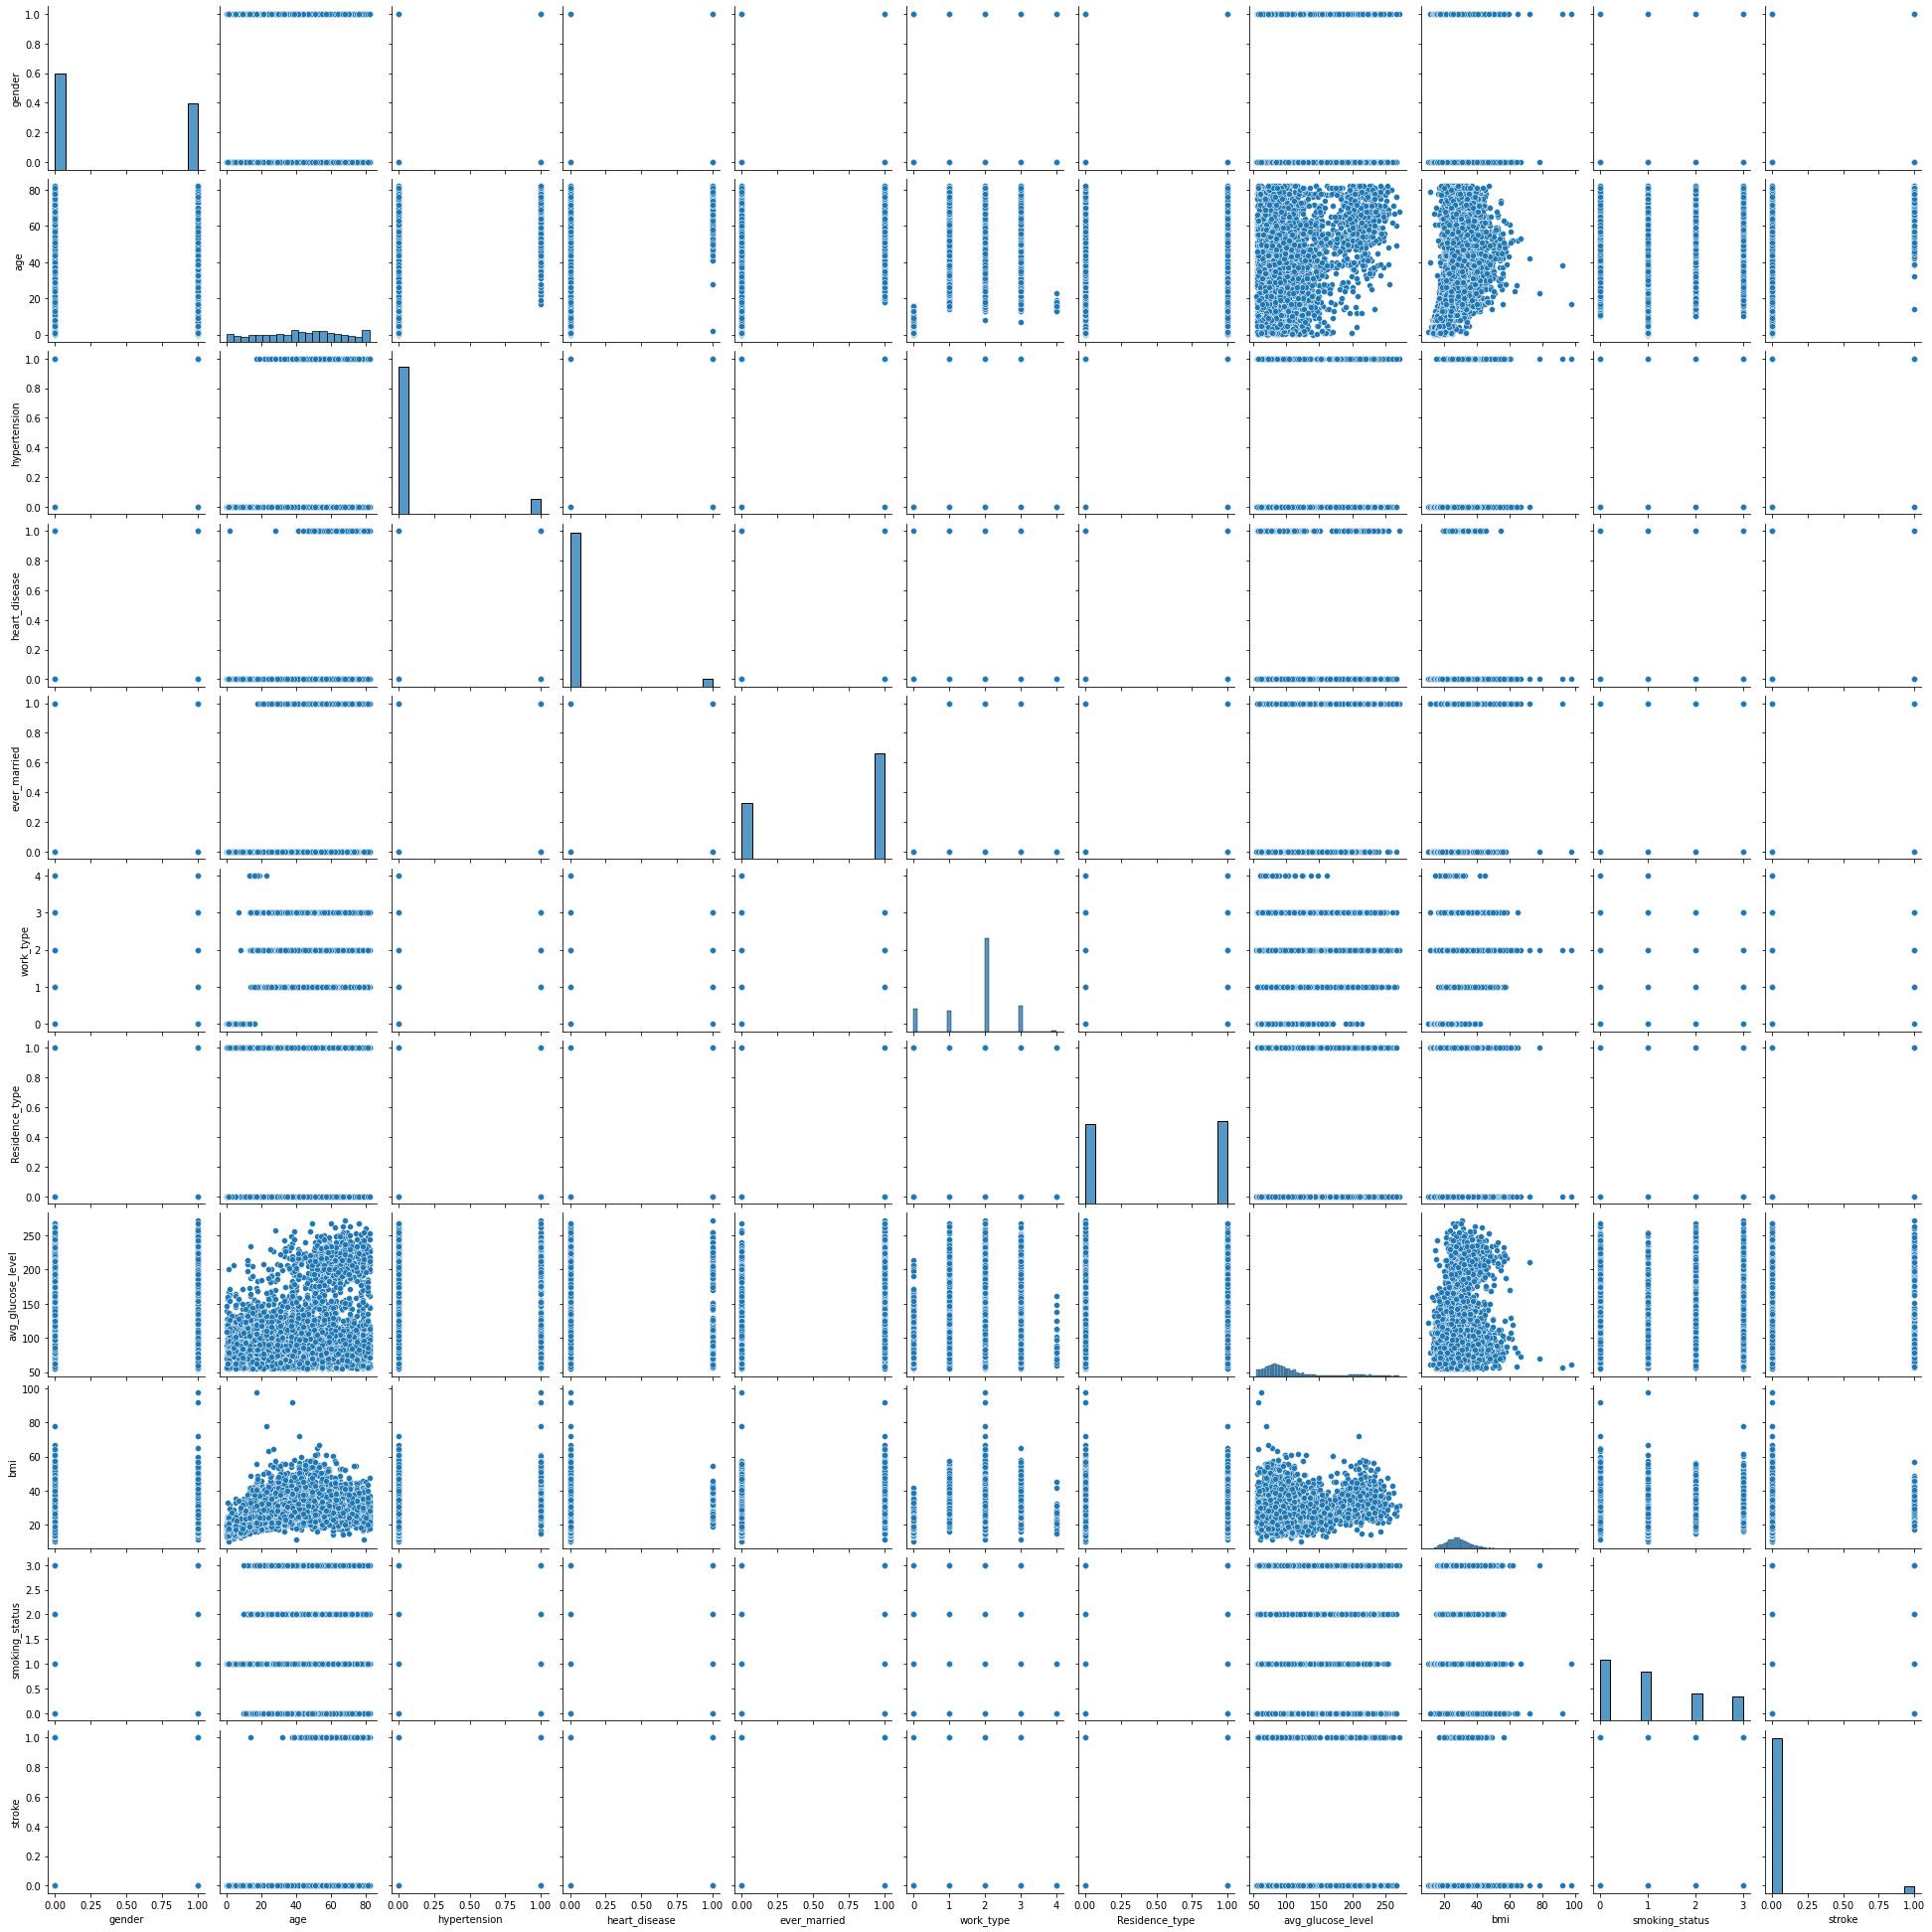

In [10]:
sns.pairplot(df)
plt.show()

C:\Python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


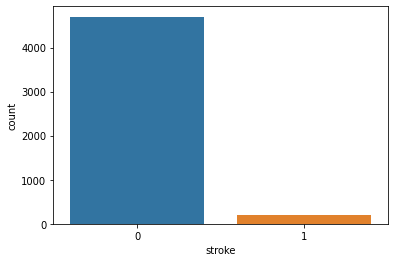

In [11]:
sns.countplot(df["stroke"], label="Count")
plt.show()

Dataset jest niezbalansowany więc teraz dzielimy dataset na dane testowe i dane treningowe oraz robimy oversampling klasy 1

In [12]:
smote = SMOTE()
test_df  = df[['gender','age','hypertension','heart_disease','ever_married','work_type','Residence_type','avg_glucose_level','bmi','smoking_status','stroke']].sample(int(df.shape[0]*0.2),random_state=1)
train_df = df.drop(index=test_df.index)

X_test, y_test   = test_df[['gender','age','hypertension','heart_disease','ever_married','work_type','Residence_type','avg_glucose_level','bmi','smoking_status']], test_df['stroke']
X_train, y_train = train_df[['gender','age','hypertension','heart_disease','ever_married','work_type','Residence_type','avg_glucose_level','bmi','smoking_status']], train_df['stroke']


X_train, y_train = smote.fit_resample(X_train, y_train)
upsampled_df = X_train.assign(Stroke = y_train)

X_test, y_test = smote.fit_resample(X_test, y_test)
up_test_df = X_test.assign(Stroke = y_test)

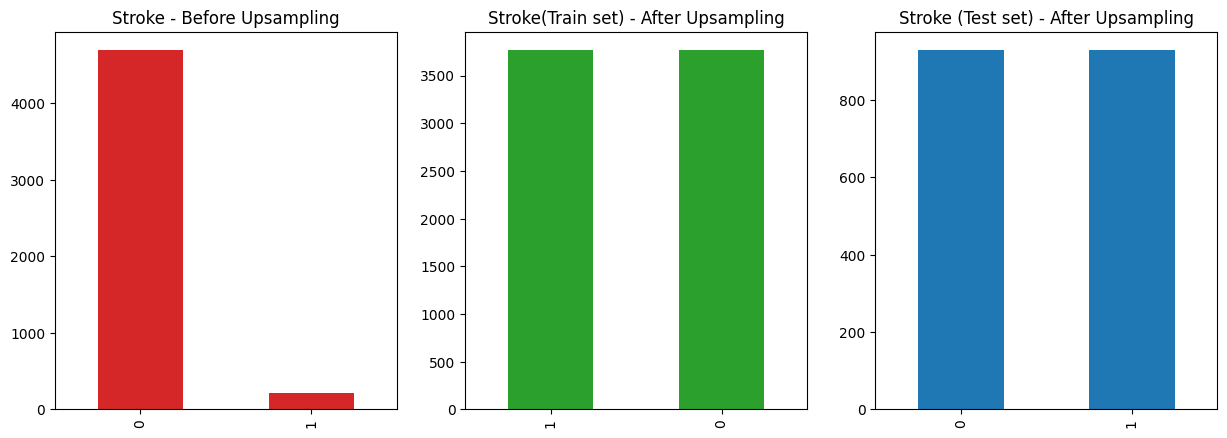

In [13]:
fig, axes = plt.subplots(nrows=1, ncols=3, dpi=100, figsize=(15, 5))

df.stroke.value_counts().plot(kind='bar', color='tab:red', title='Stroke - Before Upsampling', ax=axes[0])
upsampled_df.Stroke.value_counts().plot(kind='bar', color='tab:green', title='Stroke(Train set) - After Upsampling', ax=axes[1])
up_test_df.Stroke.value_counts().plot(kind='bar', color='tab:blue', title='Stroke (Test set) - After Upsampling', ax=axes[2]);

In [14]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

kfold = model_selection.KFold(n_splits=5, random_state=None)

import warnings
warnings.filterwarnings('ignore')

In [15]:
pipe = Pipeline([('preprocessing', StandardScaler()), ('classifier', LogisticRegression())])

param_grid = {
            'preprocessing': [StandardScaler(), None],
            'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100],
}

lr = GridSearchCV(pipe, param_grid, cv=kfold, return_train_score=True, scoring='f1')

lr.fit(X_train, y_train)
print(lr.best_params_)

y_pred_lr = lr.predict(X_test)

print(classification_report(y_test,y_pred_lr))

{'classifier__C': 1, 'preprocessing': None}
              precision    recall  f1-score   support

           0       0.83      0.79      0.81       930
           1       0.80      0.84      0.82       930

    accuracy                           0.81      1860
   macro avg       0.81      0.81      0.81      1860
weighted avg       0.81      0.81      0.81      1860



In [16]:
pipe = Pipeline([('preprocessing', StandardScaler()), ('classifier', RandomForestClassifier(class_weight='balanced'))])

param_grid = {
            'preprocessing': [StandardScaler(), None],
            'classifier__n_estimators': [8, 16, 32, 64],
            'classifier__max_leaf_nodes': [10, 20, 30, 40, 50],
}

rf = GridSearchCV(pipe, param_grid, cv=kfold, return_train_score=True, scoring='f1')

rf.fit(X_train, y_train)
print(rf.best_params_)

y_pred_rf = rf.predict(X_test)

print(classification_report(y_test,y_pred_rf))

{'classifier__max_leaf_nodes': 50, 'classifier__n_estimators': 64, 'preprocessing': StandardScaler()}
              precision    recall  f1-score   support

           0       0.78      0.85      0.81       930
           1       0.83      0.76      0.79       930

    accuracy                           0.80      1860
   macro avg       0.81      0.80      0.80      1860
weighted avg       0.81      0.80      0.80      1860



In [17]:
pipe = Pipeline([('preprocessing', StandardScaler()), ('classifier', BaggingClassifier())])

param_grid = {
            'preprocessing': [StandardScaler(), None],
            'classifier__n_estimators': [2, 4, 8, 16, 32],
            'classifier__max_samples': [0.1, 0.2, 0.4, 0.8, 1],
}

svm_bg = GridSearchCV(pipe, param_grid, cv=kfold, return_train_score=True, scoring='f1')

svm_bg.fit(X_train, y_train)

print(svm_bg.best_params_)

y_pred_svm_bg = svm_bg.predict(X_test)

print(classification_report(y_test,y_pred_svm_bg))

{'classifier__max_samples': 0.8, 'classifier__n_estimators': 16, 'preprocessing': StandardScaler()}
              precision    recall  f1-score   support

           0       0.67      0.93      0.78       930
           1       0.88      0.54      0.67       930

    accuracy                           0.73      1860
   macro avg       0.78      0.73      0.72      1860
weighted avg       0.78      0.73      0.72      1860



In [18]:
pipe = Pipeline([('preprocessing', StandardScaler()), ('classifier', KNeighborsClassifier())])

param_grid = {
            'preprocessing': [StandardScaler(), None],
            'classifier__n_neighbors': [1, 2, 4],
            'classifier__p': [1, 2, 4],
}

knn = GridSearchCV(pipe, param_grid, cv=kfold, return_train_score=True, scoring='f1')

knn.fit(X_train, y_train)
print(knn.best_params_)

y_pred_knn = knn.predict(X_test)

print(classification_report(y_test,y_pred_knn))

{'classifier__n_neighbors': 2, 'classifier__p': 1, 'preprocessing': None}
              precision    recall  f1-score   support

           0       0.58      0.88      0.70       930
           1       0.75      0.35      0.48       930

    accuracy                           0.62      1860
   macro avg       0.66      0.62      0.59      1860
weighted avg       0.66      0.62      0.59      1860



In [19]:
pipe = Pipeline([('preprocessing', StandardScaler()), ('classifier', AdaBoostClassifier())])

param_grid = {
            'preprocessing': [StandardScaler(), None],
            'classifier__n_estimators': [1, 2, 4],
            'classifier__learning_rate': [0.00001, 0.0001, 0.001, 0.01],
}

ada_boost = GridSearchCV(pipe, param_grid, cv=kfold, return_train_score=True, scoring='f1')

ada_boost.fit(X_train, y_train)

print(ada_boost.best_params_)

y_pred_ada_boost = ada_boost.predict(X_test)

print(classification_report(y_test,y_pred_ada_boost))

{'classifier__learning_rate': 1e-05, 'classifier__n_estimators': 1, 'preprocessing': StandardScaler()}
              precision    recall  f1-score   support

           0       0.92      0.61      0.74       930
           1       0.71      0.95      0.81       930

    accuracy                           0.78      1860
   macro avg       0.82      0.78      0.77      1860
weighted avg       0.82      0.78      0.77      1860



In [20]:
pipe = Pipeline([('preprocessing', StandardScaler()), ('classifier', SVC(kernel='linear', class_weight='balanced'))])

param_grid = {
            'preprocessing': [StandardScaler(), None],
            'classifier__C': [0.0001, 0.001, 0.01, 0.1, 1],
}

svm_l = GridSearchCV(pipe, param_grid, cv=kfold, return_train_score=True, scoring='f1')

svm_l.fit(X_train, y_train)

print(svm_l.best_params_)

y_pred_svm_l = svm_l.predict(X_test)

print(classification_report(y_test,y_pred_svm_l))

{'classifier__C': 0.001, 'preprocessing': StandardScaler()}
              precision    recall  f1-score   support

           0       0.83      0.76      0.79       930
           1       0.78      0.84      0.81       930

    accuracy                           0.80      1860
   macro avg       0.80      0.80      0.80      1860
weighted avg       0.80      0.80      0.80      1860



In [21]:
pipe = Pipeline([('preprocessing', StandardScaler()), ('classifier', SVC(kernel='rbf', class_weight='balanced'))])

param_grid = {
            'preprocessing': [StandardScaler(), None],
            'classifier__C': [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10],
            'classifier__gamma': [0.00001, 0.0001, 0.001, 0.01, 1, 10],
}

svm_rbf = RandomizedSearchCV(pipe, param_grid, cv=kfold, n_iter=10, return_train_score=True, scoring='f1')

svm_rbf.fit(X_train, y_train)

print(svm_rbf.best_params_)

y_pred_svm_rbf = svm_rbf.predict(X_test)

print(classification_report(y_test,y_pred_svm_rbf))

{'preprocessing': StandardScaler(), 'classifier__gamma': 1, 'classifier__C': 10}
              precision    recall  f1-score   support

           0       0.64      0.90      0.75       930
           1       0.83      0.49      0.62       930

    accuracy                           0.70      1860
   macro avg       0.73      0.70      0.68      1860
weighted avg       0.73      0.70      0.68      1860



In [22]:
pipe = Pipeline([('preprocessing', StandardScaler()), ('classifier', SVC(kernel='poly', class_weight='balanced'))])

param_grid = {
            'preprocessing': [StandardScaler(), None],
            'classifier__C': [0.0001, 0.001, 1, 10],
            'classifier__coef0': [0.0001, 0.001, 1, 10],
            'classifier__degree': [1, 2, 3, 4],
}

svm_poly = RandomizedSearchCV(pipe, param_grid, n_iter=10, cv=kfold, return_train_score=True, scoring='f1')

svm_poly.fit(X_train, y_train)

print(svm_poly.best_params_)

y_pred_svm_poly = svm_poly.predict(X_test)

print(classification_report(y_test,y_pred_svm_poly))

{'preprocessing': StandardScaler(), 'classifier__degree': 3, 'classifier__coef0': 1, 'classifier__C': 10}
              precision    recall  f1-score   support

           0       0.73      0.83      0.78       930
           1       0.80      0.69      0.74       930

    accuracy                           0.76      1860
   macro avg       0.76      0.76      0.76      1860
weighted avg       0.76      0.76      0.76      1860



In [23]:
pipe = Pipeline([('preprocessing', StandardScaler()), ('classifier', MLPClassifier())])

param_grid = {
            'preprocessing': [StandardScaler(), None],
            'classifier__hidden_layer_sizes': [(32, 16)],
            'classifier__learning_rate_init': [0.001, 0.01, 0.1],
            'classifier__max_iter': [256, 512],
            'classifier__batch_size': [10, 20, 30],
}

mlp = RandomizedSearchCV(pipe, param_grid, n_iter=10, cv=kfold, return_train_score=True, scoring='f1')

mlp.fit(X_train, y_train)

print(mlp.best_params_)

y_pred_mlp = mlp.predict(X_test)

print(classification_report(y_test,y_pred_mlp))

{'preprocessing': StandardScaler(), 'classifier__max_iter': 512, 'classifier__learning_rate_init': 0.01, 'classifier__hidden_layer_sizes': (32, 16), 'classifier__batch_size': 30}
              precision    recall  f1-score   support

           0       0.68      0.89      0.77       930
           1       0.84      0.58      0.68       930

    accuracy                           0.73      1860
   macro avg       0.76      0.73      0.72      1860
weighted avg       0.76      0.73      0.72      1860



In [24]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import History



keras_model = tf.keras.Sequential()
keras_model.add(tf.keras.layers.Dense(256, activation='relu', input_shape=(X_train.shape[1],)))
keras_model.add(tf.keras.layers.Dropout(0.2))
keras_model.add(tf.keras.layers.BatchNormalization())
keras_model.add(tf.keras.layers.Dense(256, activation='relu'))
keras_model.add(tf.keras.layers.Dropout(0.2))
keras_model.add(tf.keras.layers.BatchNormalization())
keras_model.add(tf.keras.layers.Dense(256, activation='relu'))
keras_model.add(tf.keras.layers.Dropout(0.2))
keras_model.add(tf.keras.layers.BatchNormalization())
keras_model.add(tf.keras.layers.Dense(256, activation='relu'))
keras_model.add(tf.keras.layers.Dropout(0.2))
keras_model.add(tf.keras.layers.BatchNormalization())
keras_model.add(tf.keras.layers.Dense(64, activation='relu'))
keras_model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

In [25]:
keras_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[tf.keras.metrics.Recall(), tf.keras.metrics.Precision()])

X_train_keras, X_val, y_train_keras, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=0)

In [26]:
history = keras_model.fit(X_train_keras, y_train_keras, validation_data=(X_val, y_val), batch_size=64, epochs=100, class_weight={0: 1, 1: 8})

Epoch 1/100
95/95 [==============================] - 3s 9ms/step - loss: 1.1513 - recall: 0.9817 - precision: 0.6285 - val_loss: 0.7679 - val_recall: 1.0000 - val_precision: 0.5955
Epoch 2/100
95/95 [==============================] - 1s 6ms/step - loss: 1.0389 - recall: 0.9927 - precision: 0.6357 - val_loss: 0.6797 - val_recall: 0.9987 - val_precision: 0.6424
Epoch 3/100
95/95 [==============================] - 1s 6ms/step - loss: 0.9954 - recall: 0.9947 - precision: 0.6374 - val_loss: 0.5418 - val_recall: 0.9818 - val_precision: 0.6811
Epoch 4/100
95/95 [==============================] - 1s 6ms/step - loss: 0.9892 - recall: 0.9933 - precision: 0.6364 - val_loss: 0.5664 - val_recall: 0.9883 - val_precision: 0.6764
Epoch 5/100
95/95 [==============================] - 1s 5ms/step - loss: 0.9570 - recall: 0.9943 - precision: 0.6463 - val_loss: 0.5049 - val_recall: 0.9610 - val_precision: 0.7034
Epoch 6/100
95/95 [==============================] - 1s 5ms/step - loss: 0.9418 - recall: 0.993

95/95 [==============================] - 1s 7ms/step - loss: 0.7921 - recall: 0.9900 - precision: 0.6963 - val_loss: 0.5558 - val_recall: 0.9805 - val_precision: 0.7123
Epoch 47/100
95/95 [==============================] - 1s 7ms/step - loss: 0.7935 - recall: 0.9893 - precision: 0.6948 - val_loss: 0.4843 - val_recall: 0.9779 - val_precision: 0.7268
Epoch 48/100
95/95 [==============================] - 1s 8ms/step - loss: 0.7941 - recall: 0.9903 - precision: 0.6960 - val_loss: 0.4402 - val_recall: 0.9818 - val_precision: 0.7390
Epoch 49/100
95/95 [==============================] - 1s 7ms/step - loss: 0.7834 - recall: 0.9907 - precision: 0.6991 - val_loss: 0.5756 - val_recall: 0.9909 - val_precision: 0.6880
Epoch 50/100
95/95 [==============================] - 1s 7ms/step - loss: 0.7883 - recall: 0.9917 - precision: 0.6958 - val_loss: 0.5483 - val_recall: 0.9948 - val_precision: 0.7066
Epoch 51/100
95/95 [==============================] - 1s 8ms/step - loss: 0.8098 - recall: 0.9917 - pre

95/95 [==============================] - 1s 7ms/step - loss: 0.7651 - recall: 0.9923 - precision: 0.7039 - val_loss: 0.3932 - val_recall: 0.8857 - val_precision: 0.7903
Epoch 92/100
95/95 [==============================] - 1s 7ms/step - loss: 0.7678 - recall: 0.9917 - precision: 0.7084 - val_loss: 0.4233 - val_recall: 0.9818 - val_precision: 0.7652
Epoch 93/100
95/95 [==============================] - 1s 7ms/step - loss: 0.7764 - recall: 0.9900 - precision: 0.7066 - val_loss: 0.3903 - val_recall: 0.9623 - val_precision: 0.7735
Epoch 94/100
95/95 [==============================] - 1s 7ms/step - loss: 0.7588 - recall: 0.9917 - precision: 0.7110 - val_loss: 0.4385 - val_recall: 0.9506 - val_precision: 0.7409
Epoch 95/100
95/95 [==============================] - 1s 7ms/step - loss: 0.7560 - recall: 0.9903 - precision: 0.7070 - val_loss: 0.3902 - val_recall: 0.9390 - val_precision: 0.7825
Epoch 96/100
95/95 [==============================] - 1s 7ms/step - loss: 0.7891 - recall: 0.9887 - pre

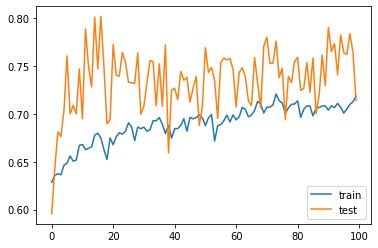

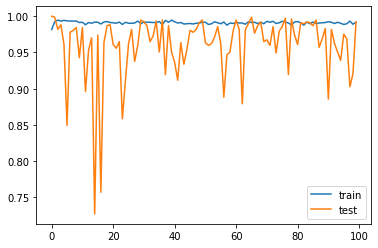

In [28]:
plt.plot(history.history['precision'], label = "train")
plt.plot(history.history['val_precision'], label = "test")
plt.legend()
plt.show()

plt.plot(history.history['recall'], label = "train")
plt.plot(history.history['val_recall'], label = "test")
plt.legend()
plt.show()

In [29]:
y_pred_keras = keras_model.predict(X_test)

59/59 [==============================] - 0s 2ms/step


In [32]:
from sklearn import metrics

models = []
models.append(('Logistic regression', lr.best_estimator_, y_pred_lr))
models.append(('SVM linear', svm_l.best_estimator_, y_pred_svm_l))
models.append(('SVM poly', svm_poly.best_estimator_, y_pred_svm_poly))
models.append(('SVM rbf', svm_rbf.best_estimator_, y_pred_svm_rbf))
models.append(('RandomForestClassifier', rf.best_estimator_, y_pred_rf))
models.append(('BaggingClassifier', svm_bg.best_estimator_, y_pred_svm_bg))
models.append(('AdaBoostClassifier', ada_boost.best_estimator_, y_pred_ada_boost))
models.append(('KNeighborsClassifier', knn.best_estimator_, y_pred_knn))
models.append(('MLPClassifier', mlp.best_estimator_, y_pred_mlp))
models.append(('Keras', keras_model, y_pred_keras))

precision = []
recall = []
f1 = []
accuracy = []
for name, model, pred in models:
    if name == 'Keras':
        pred = [round(x[0]) for x in model.predict(X_test)]
    precision.append(metrics.precision_score(y_test, pred))
    recall.append(metrics.recall_score(y_test, pred))
    f1.append( metrics.f1_score(y_test, pred))
    accuracy.append(metrics.accuracy_score(y_test, pred)) 
    roc_auc.append(metrics.roc_auc_score(y_test, pred))

59/59 [==============================] - 0s 2ms/step


In [33]:
d = {
    'precision': precision, 
    'recall': recall, 
    'f1': f1,
    'accuracy' : accuracy,
}
df = pd.DataFrame(data=d)
df.insert(loc=0, column='Model', value=['Logistic regression', 'SVM linear', 'SVM poly', 'SVM rbf', 'RandomForestClassifier',
                                        'BaggingClassifier', 'AdaBoostClassifier','KNeighborsClassifier', 'MLPClassifier', 'Keras'])
df

,Model,precision,recall,f1,accuracy
0,Logistic regression,0.800412,0.836559,0.818086,0.813978
1,SVM linear,0.775470,0.843011,0.807831,0.799462
2,SVM poly,0.801498,0.690323,0.741768,0.759677
3,SVM rbf,0.828210,0.492473,0.617667,0.695161
4,RandomForestClassifier,0.832744,0.760215,0.794829,0.803763
5,BaggingClassifier,0.883598,0.538710,0.669339,0.733871
6,AdaBoostClassifier,0.709807,0.949462,0.812328,0.780645
7,KNeighborsClassifier,0.750000,0.351613,0.478770,0.617204
8,MLPClassifier,0.837246,0.575269,0.681963,0.731720
9,Keras,0.698337,0.948387,0.804378,0.769355
